In [1]:
from pandas_datareader import data as web
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates
from mpl_finance import candlestick_ohlc

/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
#Grabbing the data from Yahoo-API
start = dt.datetime(2016,1,1)
end = dt.datetime(2019,12,31)

df = web.DataReader("AAPL", "yahoo", start, end)

In [3]:
#Or read the csv file from disk
df = pd.read_csv("stock_data.csv", sep=",", index_col = 0) #set "Date" column as index and convert to datetime
df.index = pd.to_datetime(df.index)

In [4]:
#Sanity Checks
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-01-04,105.370003,102.000000,102.610001,105.349998,67649400.0,97.948441
2016-01-05,105.849998,102.410004,105.750000,102.709999,55791000.0,95.493919
2016-01-06,102.370003,99.870003,100.559998,100.699997,68457400.0,93.625145
2016-01-07,100.129997,96.430000,98.680000,96.449997,81094400.0,89.673714
2016-01-08,99.110001,96.760002,98.550003,96.959999,70798000.0,90.147873


In [5]:
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-12-24,284.890015,282.920013,284.690002,284.269989,12119700.0,282.831299
2019-12-26,289.980011,284.700012,284.820007,289.910004,23280300.0,288.442780
2019-12-27,293.970001,288.119995,291.119995,289.799988,36566500.0,288.333313
2019-12-30,292.690002,285.220001,289.459991,291.519989,36028600.0,290.044617
2019-12-31,293.679993,289.519989,289.929993,293.649994,25201400.0,292.163818


In [6]:
df["Close"]["2016-01-05"]

102.70999908447266

In [7]:
df["Close"][1]

102.70999908447266

In [8]:
#Save data as csv
df.to_csv("stock_data.csv", sep=",")

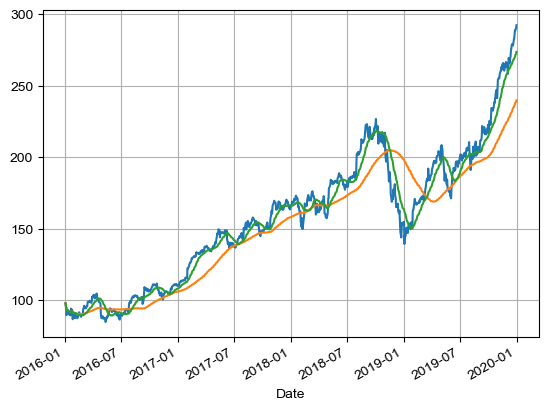

In [11]:
#Data cleaning and crafting SMAs
df.dropna(inplace=True)
df["100ma"] = df["Adj Close"].rolling(window = 100, min_periods = 0).mean()
df["25ma"] = df["Adj Close"].rolling(window = 25, min_periods = 0).mean()

#Plotting
df["Adj Close"].plot()
df["100ma"].plot()
df["25ma"].plot()
style.use("seaborn")
plt.grid(True)
plt.show()

In [12]:
df.head()

,High,Low,Open,Close,Volume,Adj Close,100ma,25ma
Date,,,,,,,,
2016-01-04,105.370003,102.000000,102.610001,105.349998,67649400.0,97.948441,97.948441,97.948441
2016-01-05,105.849998,102.410004,105.750000,102.709999,55791000.0,95.493919,96.721180,96.721180
2016-01-06,102.370003,99.870003,100.559998,100.699997,68457400.0,93.625145,95.689168,95.689168
2016-01-07,100.129997,96.430000,98.680000,96.449997,81094400.0,89.673714,94.185305,94.185305
2016-01-08,99.110001,96.760002,98.550003,96.959999,70798000.0,90.147873,93.377818,93.377818


In [13]:
df["ChangePct"] = ((df["Close"] - df["Open"]) / df["Open"]) * 100

In [14]:
df["ChangePts"] = (df["Close"] - df["Open"])

In [15]:
df["VolatilityPct"] = (df["High"] - df["Low"]) / df["Close"] * 100

In [16]:
df.head()

,High,Low,Open,Close,Volume,Adj Close,100ma,25ma,ChangePct,ChangePts,VolatilityPct
Date,,,,,,,,,,,
2016-01-04,105.370003,102.000000,102.610001,105.349998,67649400.0,97.948441,97.948441,97.948441,2.670303,2.739998,3.198864
2016-01-05,105.849998,102.410004,105.750000,102.709999,55791000.0,95.493919,96.721180,96.721180,-2.874705,-3.040001,3.349231
2016-01-06,102.370003,99.870003,100.559998,100.699997,68457400.0,93.625145,95.689168,95.689168,0.139220,0.139999,2.482622
2016-01-07,100.129997,96.430000,98.680000,96.449997,81094400.0,89.673714,94.185305,94.185305,-2.259833,-2.230003,3.836182
2016-01-08,99.110001,96.760002,98.550003,96.959999,70798000.0,90.147873,93.377818,93.377818,-1.613398,-1.590004,2.423678


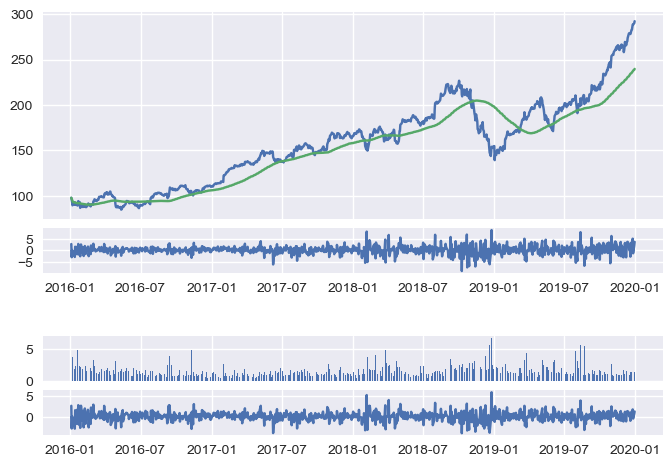

In [17]:
# Adding Subplots
ax1 = plt.subplot2grid((8,1), (0,0), rowspan=4, colspan=1) # window size, start position, plot size (4 x 1)
ax2 = plt.subplot2grid((8,1), (4,0), rowspan=1, colspan=1, sharex=ax1) #...both plots have same axis (1 x 1)
ax3 = plt.subplot2grid((8,1), (6,0), rowspan=1, colspan=1, sharex=ax1) #...both plots have same axis (1 x 1)
ax4 = plt.subplot2grid((8,1), (7,0), rowspan=1, colspan=1, sharex=ax1) #...both plots have same axis (1 x 1)

ax1.plot(df.index, df["Adj Close"])
ax1.plot(df.index, df["100ma"])
ax2.plot(df.index, df["ChangePts"])
ax3.bar(df.index, df["VolatilityPct"])
ax4.plot(df.index, df["ChangePct"])

### Candlestick Charts

In [18]:
df_ohlc = df["Adj Close"].resample("10D").ohlc()

In [19]:
df_ohlc.head()

,open,high,low,close
Date,,,,
2016-01-04,97.948441,97.948441,89.673714,90.547684
2016-01-14,92.528015,94.294540,89.534256,94.294540
2016-01-24,92.453667,92.965019,86.856606,87.842140
2016-02-03,89.580750,90.300537,87.589630,87.860733
2016-02-13,90.337929,91.721420,89.777054,90.562263


In [20]:
df_volume = df["Volume"].resample("10D").sum()

In [21]:
df_volume.head()

Date
2016-01-04    505123400.0
2016-01-14    386388100.0
2016-01-24    458637200.0
2016-02-03    369976400.0
2016-02-13    202597100.0
Freq: 10D, Name: Volume, dtype: float64

In [22]:
df_ohlc.reset_index(inplace=True) #mpl_finance can't work with datetime, therefore: create empty index
df_ohlc["Date"] = df_ohlc["Date"].map(mdates.date2num) # and map each real Date to a numeric Date number

In [23]:
df_ohlc.head()

,Date,open,high,low,close
0,735967.0,97.948441,97.948441,89.673714,90.547684
1,735977.0,92.528015,94.294540,89.534256,94.294540
2,735987.0,92.453667,92.965019,86.856606,87.842140
3,735997.0,89.580750,90.300537,87.589630,87.860733
4,736007.0,90.337929,91.721420,89.777054,90.562263


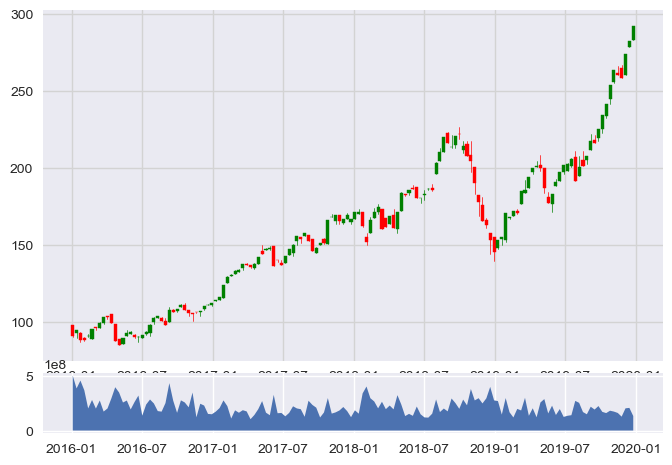

In [24]:
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1) # window size, start position, plot size (5 x 1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=ax1) #...both plots have same axis (1 x 1)
ax1.xaxis_date() # plots date on x-axis 
candlestick_ohlc(ax1, df_ohlc.values, width=8, colorup="g", colordown="r") #creates the candlesticks

ax2.fill_between(df_volume.index.map(mdates.date2num), df_volume.values) # converted dates as index, volume as y-axis
ax1.grid(True, color="lightgray") #changes gridcolor
plt.show()

### Webscraping

In [25]:
import bs4 as bs
import requests
import pickle

def lade_sp500_ticker():
    response = requests.get("https://en.wikipedia.org/wiki/list_of_S%26P_500_companies") #get sourcecode
    soup = bs.BeautifulSoup(response.text, "lxml")
    
    tabelle = soup.find("table")
    tickers = []
    
    for reihe in tabelle.findAll("tr")[1:]:
        ticker = reihe.findAll("td")[0].text.rstrip("\n")
        tickers.append(ticker)
    with open("sp500tickers.pickle", "wb") as f:
        pickle.dump(tickers, f)
    return tickers


lade_sp500_ticker()

['MMM',
 'ABT',
 'ABBV',
 'ABMD',
 'ACN',
 'ATVI',
 'ADBE',
 'AMD',
 'AAP',
 'AES',
 'AFL',
 'A',
 'APD',
 'AKAM',
 'ALK',
 'ALB',
 'ARE',
 'ALXN',
 'ALGN',
 'ALLE',
 'LNT',
 'ALL',
 'GOOGL',
 'GOOG',
 'MO',
 'AMZN',
 'AMCR',
 'AEE',
 'AAL',
 'AEP',
 'AXP',
 'AIG',
 'AMT',
 'AWK',
 'AMP',
 'ABC',
 'AME',
 'AMGN',
 'APH',
 'ADI',
 'ANSS',
 'ANTM',
 'AON',
 'AOS',
 'APA',
 'AIV',
 'AAPL',
 'AMAT',
 'APTV',
 'ADM',
 'ANET',
 'AJG',
 'AIZ',
 'T',
 'ATO',
 'ADSK',
 'ADP',
 'AZO',
 'AVB',
 'AVY',
 'BKR',
 'BLL',
 'BAC',
 'BK',
 'BAX',
 'BDX',
 'BRK.B',
 'BBY',
 'BIO',
 'BIIB',
 'BLK',
 'BA',
 'BKNG',
 'BWA',
 'BXP',
 'BSX',
 'BMY',
 'AVGO',
 'BR',
 'BF.B',
 'CHRW',
 'COG',
 'CDNS',
 'CPB',
 'COF',
 'CAH',
 'KMX',
 'CCL',
 'CARR',
 'CAT',
 'CBOE',
 'CBRE',
 'CDW',
 'CE',
 'CNC',
 'CNP',
 'CTL',
 'CERN',
 'CF',
 'SCHW',
 'CHTR',
 'CVX',
 'CMG',
 'CB',
 'CHD',
 'CI',
 'CINF',
 'CTAS',
 'CSCO',
 'C',
 'CFG',
 'CTXS',
 'CLX',
 'CME',
 'CMS',
 'KO',
 'CTSH',
 'CL',
 'CMCSA',
 'CMA',
 'CAG',
 'CXO'